![](http://wiki.swarma.net/images/e/e7/集智AI学园首页左上角logo_2017.8.17.png)

# 火炬上的深度学习（下）第二节：机器也懂感情？

## 课后练习：使用 LSTM 来判断人名属于哪个国家

我们要使用 PyTorch 搭建一个 LSTM 模型。

模型的输入是用ASCII字符表示的姓氏，输出是模型对这个姓氏所属语言的判断。

模型的训练数据是来自18种语言的2万条左右的姓氏文本。

训练完毕的理想模型可以预测出一个姓氏是属于哪种语言的。并且，我们还可以通过模型的预测结果分析各语言姓氏的相似性。

最终训练好的模型可以像下面那样使用。

```python
predict Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

## 理解 LSTM

看到本练习相信你已经对 LSTM 有一定的认识了。

如果还不熟悉 LSTM 可以再去看一下张老师讲的[课程](http://campus.swarma.org/gcou=10341)

## 处理训练数据

在提供的数据文件中，包含在 data/names 目录下的是18个命名规则为"[Language].txt"的文本文件，每个文件都包含一些名字，每个名字占一行。

In [1]:
import glob

all_filenames = glob.glob('./data/names/*.txt')
print(all_filenames)

['./data/names\\Arabic.txt', './data/names\\Chinese.txt', './data/names\\Czech.txt', './data/names\\Dutch.txt', './data/names\\English.txt', './data/names\\French.txt', './data/names\\German.txt', './data/names\\Greek.txt', './data/names\\Irish.txt', './data/names\\Italian.txt', './data/names\\Japanese.txt', './data/names\\Korean.txt', './data/names\\Polish.txt', './data/names\\Portuguese.txt', './data/names\\Russian.txt', './data/names\\Scottish.txt', './data/names\\Spanish.txt', './data/names\\Vietnamese.txt']


现在先让我们解决这个问题：

在我们收集的18种语言的名字中，中文、日文、韩文等名字都已经转化为音译的字母。这样做是因为有些语言的名字并不能用普通的ASCII英文字符来表示，比如“Ślusàrski”，这些不一样的字母会增加神经网络的“困惑”，影响其训练效果。所以我们得首先把这些特别的字母转换成普通的ASCII字符（即26个英文字母）。

In [2]:
import unicodedata
import string

# 使用26个英文字母大小写再加上.,;这三个字符
# 建立字母表，并取其长度
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


# 将Unicode字符串转换为纯ASCII
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))
print('all_letters:', all_letters)
print('all_letters:', len(all_letters))

Slusarski
all_letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
all_letters: 57


然后再建立 readLines 方法，用于从文件中一行一行的将姓氏读取出来。

以18种语言为索引，将读取出的姓氏各自存储在名为 `category_lines` 的字典中。

In [3]:
# 构建category_lines字典，名字和每种语言对应的列表
category_lines = {}
all_categories = []

# 按行读取出名字并转换成纯ASCII
def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    # 取出每个文件的文件名（语言名）
    category = filename.split('/')[-1].split('.')[0]
    # 将语言名加入到all_categories列表
    all_categories.append(category)
    # 取出所有的姓氏lines
    lines = readLines(filename)
    # 将所有姓氏以语言为索引，加入到字典中
    category_lines[category] = lines

n_categories = len(all_categories)

print('all_categories:', all_categories)
print('n_categories =', n_categories)

all_categories: ['names\\Arabic', 'names\\Chinese', 'names\\Czech', 'names\\Dutch', 'names\\English', 'names\\French', 'names\\German', 'names\\Greek', 'names\\Irish', 'names\\Italian', 'names\\Japanese', 'names\\Korean', 'names\\Polish', 'names\\Portuguese', 'names\\Russian', 'names\\Scottish', 'names\\Spanish', 'names\\Vietnamese']
n_categories = 18


`all_categories` 中包含18中语言的姓氏。

`category_lines` 中以18中语言为索引，存储了所有的姓氏。

In [4]:
print(category_lines['names\\Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


我们来统计下数据中所有姓氏的个数。

In [5]:
all_line_num = 0
for key in category_lines:
    all_line_num += len(category_lines[key])
print(all_line_num)

20074


## 准备训练

In [6]:
# 首先导入程序所需要的程序包

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable


#绘图、计算用的程序包
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np

%matplotlib inline

下面我们再编写一个方法用于快速地获得一个训练实例（即一个名字以及它所属的语言）：

其中 line_index 中保存的是选择的姓氏中的字母的索引，这个需要你去实现。

In [153]:

print('all_letters:', all_letters)
all_letters.index('z')
print("all_letters.index('y'):", all_letters.index('y'))
print("all_letters.index('A'):", all_letters.index('A'))
print("all_letters.index('z'):", all_letters.index('z'))
print("all_letters.index(' '):", all_letters.index(' '))
print("all_letters.index(','):", all_letters.index(','))
print("all_letters.index('\''):", all_letters.index('\''))

for letter in 'Nazari ' :
        if(letter=='z'):
            line_index.append(25)
        elif (letter==' '):
            line_index.append(52)
        else: 
            line_index.append(all_letter.index(letter))
print('all_letter.index(letter) =',all_letter.index(letter))
[all_letter.index(unicode_to_ascii(letter)) for letter in 'Nazari ']

all_letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
all_letters.index('y'): 24
all_letters.index('A'): 26
all_letters.index('z'): 25
all_letters.index(' '): 52
all_letters.index(','): 54
all_letters.index('''): 56


ValueError: ' ' is not in list

In [155]:
import random
    
def random_training_pair():   
    # 随机选择一种语言
    category = random.choice(all_categories)
    # 从语言中随机选择一个姓氏
    line = random.choice(category_lines[category])
    # 我们将姓氏和语言都转化为索引
    category_index = all_categories.index(category)
    #print(category_lines[category])
  # for letter in
    #print('category =', category, '/ line =', line)
    line_index =[]
    for letter in line :
        if(letter=='z'):
            line_index.append(25)
        elif (letter==' '):
            line_index.append(52)
        elif (letter==','):
            line_index.append(54)
        elif (letter==';'):
            line_index.append(55)
        elif (letter=='\''):
            line_index.append(56)
        else: 
            line_index.append(all_letter.index(letter))
       # print('letter =',letter)
      #  print('all_letter.index(letter) =',all_letter.index(letter))
       # line_index.append[index]
   # line_index =  [all_letter.index(letter) for letter in line]
    # 你需要把 line 中字母的索引加入到line_index 中
    # Todo:
    
    
    return category, line, category_index, line_index

# 测试一下上面的函数方法
#print('category =', len(all_categories))
for i in range(5):
    category, line, category_index, line_index = random_training_pair()
    print('category =', category, '/ line =', line)
    print('category =', category_index, '/ line =', line_index)

category = names\Spanish / line = Garrastazu
category = 16 / line = [6, 26, 43, 43, 26, 44, 45, 26, 25, 46]
category = names\Japanese / line = Horri
category = 10 / line = [7, 40, 43, 43, 34]
category = names\German / line = Kempf
category = 6 / line = [10, 30, 38, 41, 31]
category = names\Italian / line = Mondadori
category = 9 / line = [12, 40, 39, 29, 26, 29, 40, 43, 34]
category = names\Korean / line = Jeong
category = 11 / line = [9, 30, 40, 39, 32]


我们再建立一个用户转化模型输出的辅助函数。

它可以把网络的输出（1 x 18的张量）转化成“最可能的语言类别”，这就需要找到18列数据中哪个概率值最大。

我们可以使用 `Tensor.topk` 方法来得到数据中最大值位置的索引。

In [133]:
def category_from_output(output):
    # 1 代表在‘列’间找到最大
    # top_n 是具体的值
    # top_i 是位置索引
    # 注意这里 top_n 和 top_i 都是1x1的张量
    # output.data 取出张量数据
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    # 从张量中取出索引值
    category_i = top_i[0][0]
    # 返回语言类别名和位置索引
    return all_categories[category_i], category_i

## 编写 LSTM 模型

现在是建立 LSTM 模型的时候了。

我在模型中设置了一些空缺，**你需要编写空缺处的代码。**

如果遇到问题，可以参考[课程](http://campus.swarma.org/gcou=10341)中的代码讲解哦！

In [95]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTMNetwork, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        # LSTM的构造如下：
        # 一个embedding层，将输入的任意一个单词（list）映射为一个向量（向量的维度与隐含层有关系？）
        self.embedding =  nn.Embedding(input_size, hidden_size)
        # 然后是一个LSTM隐含层，共有hidden_size个LSTM神经元，并且它可以根据n_layers设置层数
        self.lstm =  nn.LSTM(hidden_size, 10, n_layers)
        # 接着是一个全链接层，外接一个softmax输出
        self.fc = nn.Linear(10, 18)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self, input, hidden=None):
        #首先根据输入input，进行词向量嵌入
        embedded = self.embedding(input)
        
        # 这里需要注意！
        # PyTorch设计的LSTM层有一个特别别扭的地方是，输入张量的第一个维度需要是时间步，
        # 第二个维度才是batch_size，所以需要对embedded变形
        # 因为此次没有采用batch，所以batch_size为1
        # 变形的维度应该是（input_list_size, batch_size, hidden_size）
        embedded = embedded.view(input.data.size()[0], 1, self.hidden_size)
    
        # 调用PyTorch自带的LSTM层函数，注意有两个输入，一个是输入层的输入，另一个是隐含层自身的输入
        # 输出output是所有步的隐含神经元的输出结果，hidden是隐含层在最后一个时间步的状态。
        # 注意hidden是一个tuple，包含了最后时间步的隐含层神经元的输出，以及每一个隐含层神经元的cell的状态
        
        
        
        output, hidden = self.lstm(embedded, hidden)
        
        #我们要把最后一个时间步的隐含神经元输出结果拿出来，送给全连接层
        output = output[-1,...]

        #全链接层
        out = self.fc(output)
        # softmax
        out = self.logsoftmax(out)
        return out

    def initHidden(self):
        # 对隐单元的初始化
        # 对引单元输出的初始化，全0.
        # 注意hidden和cell的维度都是layers,batch_size,hidden_size
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        # 对隐单元内部的状态cell的初始化，全0
        cell = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        return (hidden, cell)



## 训练网络

每次训练模型的时候，我的心里都是有点小激动的！

我同样在训练程序中预留了一些空位，**你要编写空余位置的程序**，训练才可以正常进行。

In [156]:
import time
import math

# 开始训练LSTM网络
n_epochs = 100000

# 构造一个LSTM网络的实例
lstm = LSTMNetwork(n_letters, 10, n_categories, 2)

#定义损失函数
cost = torch.nn.NLLLoss()

#定义优化器,
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)
records = []

# 用于计算训练时间的函数
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

# 开始训练，一共5个epoch，否则容易过拟合
for epoch in range(5):
    losses = []
    #每次随机选择数据进行训练，每个 EPOCH 训练“所有名字个数”次。
    for i in range(all_line_num):
        category, line, y, x = random_training_pair()
        
        #print("x1")
        #print(x)
        x = Variable(torch.LongTensor(x))
        #print("x2")
       # print(x)
        #y = Variable(torch.LongTensor(np.array([y], dtype=np.int64)))
        y = Variable(torch.LongTensor([y]))
        optimizer.zero_grad()
        
        # Step1:初始化LSTM隐含层单元的状态
        hidden = lstm.initHidden()
        
        # Step2:让LSTM开始做运算，注意，不需要手工编写对时间步的循环，而是直接交给PyTorch的LSTM层。
        # 它自动会根据数据的维度计算若干时间步
        #print(x)
        #print(hidden)
        output = lstm(x, hidden)
        
        # Step3:计算损失
        loss = cost(output, y)
        losses.append(loss.data.numpy()[0])
        
        #反向传播
        loss.backward()
        optimizer.step()
        
        #每隔3000步，跑一次校验集，并打印结果
        if i % 3000 == 0:
            # 判断模型的预测是否正确
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            # 计算训练进度
            training_process = (all_line_num * epoch + i) / (all_line_num * 5) * 100
            training_process = '%.2f' % training_process
            print('第{}轮，训练损失：{:.2f}，训练进度：{}%，（{}），名字：{}，预测国家：{}，正确？{}'\
                .format(epoch, np.mean(losses), float(training_process), time_since(start), line, guess, correct))
            records.append([np.mean(losses)])

第0轮，训练损失：3.26，训练进度：0.0%，（0m 0s），名字：O'Keeffe，预测国家：names\Scottish，正确？✗ (names\Irish)
第0轮，训练损失：2.70，训练进度：2.99%，（0m 49s），名字：Pho，预测国家：names\Vietnamese，正确？✓
第0轮，训练损失：2.50，训练进度：5.98%，（1m 38s），名字：Nevin，预测国家：names\Irish，正确？✓
第0轮，训练损失：2.34，训练进度：8.97%，（2m 28s），名字：Iijima，预测国家：names\Japanese，正确？✓
第0轮，训练损失：2.23，训练进度：11.96%，（3m 16s），名字：Bagni，预测国家：names\Italian，正确？✓
第0轮，训练损失：2.15，训练进度：14.94%，（4m 5s），名字：Wojewdzki，预测国家：names\Polish，正确？✓
第0轮，训练损失：2.09，训练进度：17.93%，（4m 54s），名字：Nardovino，预测国家：names\Italian，正确？✓
第1轮，训练损失：3.23，训练进度：20.0%，（5m 29s），名字：Chmiel，预测国家：names\English，正确？✗ (names\Polish)
第1轮，训练损失：1.63，训练进度：22.99%，（6m 18s），名字：Thomas，预测国家：names\Arabic，正确？✗ (names\French)
第1轮，训练损失：1.65，训练进度：25.98%，（7m 7s），名字：Trieu，预测国家：names\Vietnamese，正确？✓
第1轮，训练损失：1.64，训练进度：28.97%，（7m 59s），名字：Tong，预测国家：names\Vietnamese，正确？✗ (names\English)
第1轮，训练损失：1.62，训练进度：31.96%，（8m 48s），名字：Sklavenitis，预测国家：names\Greek，正确？✓
第1轮，训练损失：1.61，训练进度：34.94%，（9m 39s），名字：Leeuwenhoek，预测国家：names\Polish，正确？✗ (names\Dutch)
第1轮，训练损失：1.59，训练进度：37.93

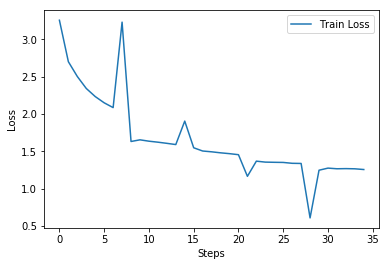

In [157]:
a = [i[0] for i in records]
plt.plot(a, label = 'Train Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

## 通过姓氏分析语言的相似性

激动人心的时刻到了！

下面将使用10000条数据评估训练好的模型，并根据评估的结果绘制图形，从图形中我们可以发现哪些语言的姓氏是相似的！

**你需要自行编写 evaluate 函数的内容。**

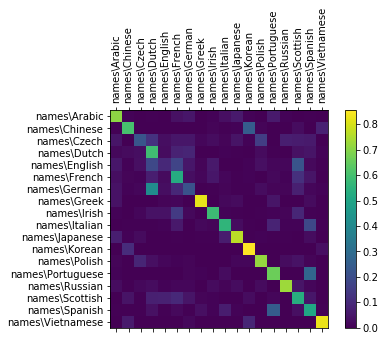

In [158]:
import matplotlib.pyplot as plt


# 建立一个（18 x 18）的方阵张量
# 用于保存神经网络做出的预测结果
confusion = torch.zeros(n_categories, n_categories)
# 用于评估的模型的测试次数
n_confusion = 10000


# 评估用方法 传进去一个名字，给出预测结果
# 可以观察到这个方法的实现与 train 方法前半部分类似
# 其实它就是去掉反向传播的 train 方法
def evaluate(line_list):
    # 调用模型前应该先初始化模型的隐含层
    hidden = lstm.initHidden()
    # 别忘了将输入的list转化为torch.Variable
    line_variable =  Variable(torch.LongTensor(line_list))
    # 调用模型
    output = lstm(line_variable, hidden)
    
    return output

# 循环一万次
for i in range(n_confusion):
    # 随机选择测试数据，包括姓氏以及所属语言
    category, line, category_index, line_list = random_training_pair()
    # 取得预测结果
    output = evaluate(line_list)
    
    # 取得预测结果的语言和索引
    guess, guess_i = category_from_output(output)
    
    # 以姓氏实际的所属语言为行
    # 以模型预测的所属语言为列
    # 在方阵的特定位置增加1

    confusion[category_index][guess_i] += 1

# 数据归一化
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 设置一个图表
fig = plt.figure()
ax = fig.add_subplot(111)
# 将 confusion 方阵数据传入
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 设置图表两边的语言类别名称
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

先看行再看列，行标签代表姓氏实际所属语言，列标签代表模型预测姓氏所属语言。

色块颜色越亮代表预测次数越高。整张图表中对角线最亮，说明模型对大部分数据的预测都是准确的。

但是！我们要观察的是预测错误的情况，即对角线以外的亮色块！

先看 English 这一行，可以看到 English 对角线上的色块很暗啊，说明模型对英文姓氏的预测很差。同时，除对角线方块外，在 English 这一行可以观察到很多浅色方块，它们分别是：Czech（捷克语）、French（法语）、German（德语）、Irish（爱尔兰语）、Scottish（苏格兰语）。这些国家文化相近，姓氏相似，所以模型没能做到非常好的区分。

而东方国家，让我们观察中国这一行，可以看到中国、韩国、越南（Vietnamese）的姓氏有一定的相似度，这与国家间的文化是相符的。

另外还有西班牙和葡萄牙，这两个国家的姓氏也有些相似。

## 将模型封装的更易用

我们重新把焦点转移到训练的模型上来。

下面我要编写一个函数将训练的模型封装起来，以便于调用。

In [34]:
# predict函数
# 第一个参数为要进行预测的姓氏
# 第二个参数为预测最大可能所属语言的数量
def predict(input_line, n_predictions=3):
    # 首先将用户输入的名字打印出来
    print('\n> %s' % input_line)
    # 将用户输入的字符串转化为索引列表
    input_line = list(map(lambda x: all_letters.find(x), input_line))
    # 将用户输入的名字传入模型中进行预测
    output = evaluate(input_line)

    # 获得概率最大的n_predictions个语言类别
    topv, topi = output.data.topk(n_predictions, 1, True)
    # topv中保存着概率值
    # topi中保存着位置索引

    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        # 将预测概率最大的三种语言类别格式化后打印出来
        print('(%.2f) %s' % (value, all_categories[category_index]))
        # 将它们存储到 predictions 中
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Han')


> Dovesky


NameError: name 'evaluate' is not defined

到这里本次练习就结束了，希望本次练习可以加深你对 LSTM 的认识。如果在练习中遇到了问题，可以在 火炬上的深度学习 课程讨论群 中进行提问，对不模型有不明白的地方，可以再重复学习下课程视频中的讲解。

![](http://wiki.swarma.net/images/c/ca/AI学园.jpg)